### Библиотеки 

    !pip install umap

    !pip install umap-learn

    !pip install fast-histogram colorcet

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
import pickle

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from tqdm import tqdm 

In [3]:
import sklearn

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn import preprocessing

import umap.umap_ as umap

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [5]:
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN

In [6]:
from sklearn.model_selection import train_test_split

### Загрузка датасета

In [7]:
from sklearn import datasets

data = datasets.load_breast_cancer()
    
df = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target


In [8]:
list(zip(*np.unique(y, return_counts=True)))

[(0, 212), (1, 357)]

In [9]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(df)

X = standard_scaler.transform(df)
X = pd.DataFrame(X, index=df.index, columns=df.columns)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Функции

In [11]:
def get_decomposition(X_train, X_test, algo, name=None, save=False): 
    
    X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
    
    decomposition = algo.fit_transform(X)
    
    if save:         
        path = 'decompositions/decomposition_' + name + '.pickle'
        with open(path, 'wb') as f:
            pickle.dump(decomposition, f)
            
    return decomposition

In [12]:
def score_table(y_true, y_pred, name='score'): 
    
    scores = [recall_score(y_true, y_pred, average='macro'), 
              precision_score(y_true, y_pred, average='macro'), 
              accuracy_score(y_true, y_pred), 
              balanced_accuracy_score(y_true, y_pred), 
              cohen_kappa_score(y_true, y_pred), 
              f1_score(y_true, y_pred, average='macro'), 
              matthews_corrcoef(y_true, y_pred)]

    index = ['recall_score', 'precision_score', 'accuracy_score', 'balanced_accuracy_score',
             'cohen_kappa_score', 'f1_score', 'matthews_corrcoef']
    
    return pd.DataFrame(scores, index=index, columns=[name])

In [13]:
def plot_decompositions(decompositions, label_true, label_pred):
    
    nrows = 5
    ncols = 2

    fig, ax = plt.subplots(nrows, ncols, figsize=(15, 21))
    
    for i in range(nrows):
        
        scatter = ax[i, 0].scatter(*np.transpose(decompositions[i][0]), c=label_true)
        handles, _ = scatter.legend_elements(prop="colors", alpha=1)
        ax[i, 0].legend(handles, labels, prop={'size': 6}, title="Classes")
        ax[i, 0].set_title('True label - ' + decompositions[i][1])

        scatter = ax[i, 1].scatter(*np.transpose(decompositions[i][0]), c=label_pred)
        handles, _ = scatter.legend_elements(prop="colors", alpha=1)
        ax[i, 1].legend(handles, labels, prop={'size': 6}, title="Classes")
        ax[i, 1].set_title('Prediction - ' + decompositions[i][1])
    
    plt.show()

https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan

In [14]:
def dbscan_predict(model, X_test, metric=sp.spatial.distance.euclidean):

    y_test = np.ones(shape=len(X_test), dtype=int) * -1 
    
    for j, x in enumerate(np.array(X_test)):
        for i, x_core in enumerate(model.components_): 
            if metric(x, x_core) < model.eps:
                y_test[j] = model.labels_[model.core_sample_indices_[i]] 
                break

    return y_test + 1

In [15]:
def clustering(model, X_train, y_train, X_test, y_test, decompositions, labels):
    
    fitted_model = model.fit(X_train) 
    
    if model.__class__.__name__ == 'DBSCAN': 
        y_train_pred = fitted_model.labels_ + 1
        y_test_pred = dbscan_predict(model, X_test) 
    
    elif model.__class__.__name__ == 'KMeans':
        y_train_pred = fitted_model.labels_
        y_test_pred = fitted_model.predict(X_test)
        
    print('confusion matrix (train)\n', confusion_matrix(y_train, y_train_pred))
    print('\nconfusion matrix (test)\n',confusion_matrix(y_test, y_test_pred))
    
    table = pd.concat([score_table(y_train, y_train_pred, name='train'),
                       score_table(y_test, y_test_pred, name='test')], axis=1)
        
    label_true = pd.concat([pd.Series(y_train), 
                            pd.Series(y_test).apply(lambda x: x+2)], axis=0) 
    
    label_pred = pd.concat([pd.Series(y_train_pred), 
                            pd.Series(y_test_pred).apply(lambda x: x+2)], axis=0) 
    
    plot_decompositions(decompositions, label_true, label_pred)
    
    return table

### Разложения

In [16]:
random_state=666

algo = [(TSNE(n_components=2, random_state=random_state, learning_rate=150), 'TSNE'),
        (PCA(n_components=2, random_state=random_state), 'PCA'), 
        (random_projection.SparseRandomProjection(n_components = 2, random_state=random_state), 'Random Projection'),
        (random_projection.GaussianRandomProjection(n_components = 2, random_state=random_state), 'Gaussian mixture'), 
        (umap.UMAP(n_components = 2, random_state=random_state), 'UMAP')]

decompositions = [(get_decomposition(X_train, X_test, i[0], name=i[1], save=True), i[1]) for i in tqdm(algo)]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


In [17]:
labels = ['0 train', '1 train', '0 test', '1 test']

## K-Means

In [18]:
model_kmeans = KMeans(n_clusters=2, random_state=42).fit(X)

In [19]:
list(zip(*np.unique(model_kmeans.labels_, return_counts=True)))

[(0, 189), (1, 380)]

confusion matrix (train)
 [[120  25]
 [ 10 226]]

confusion matrix (test)
 [[ 56  11]
 [  8 113]]


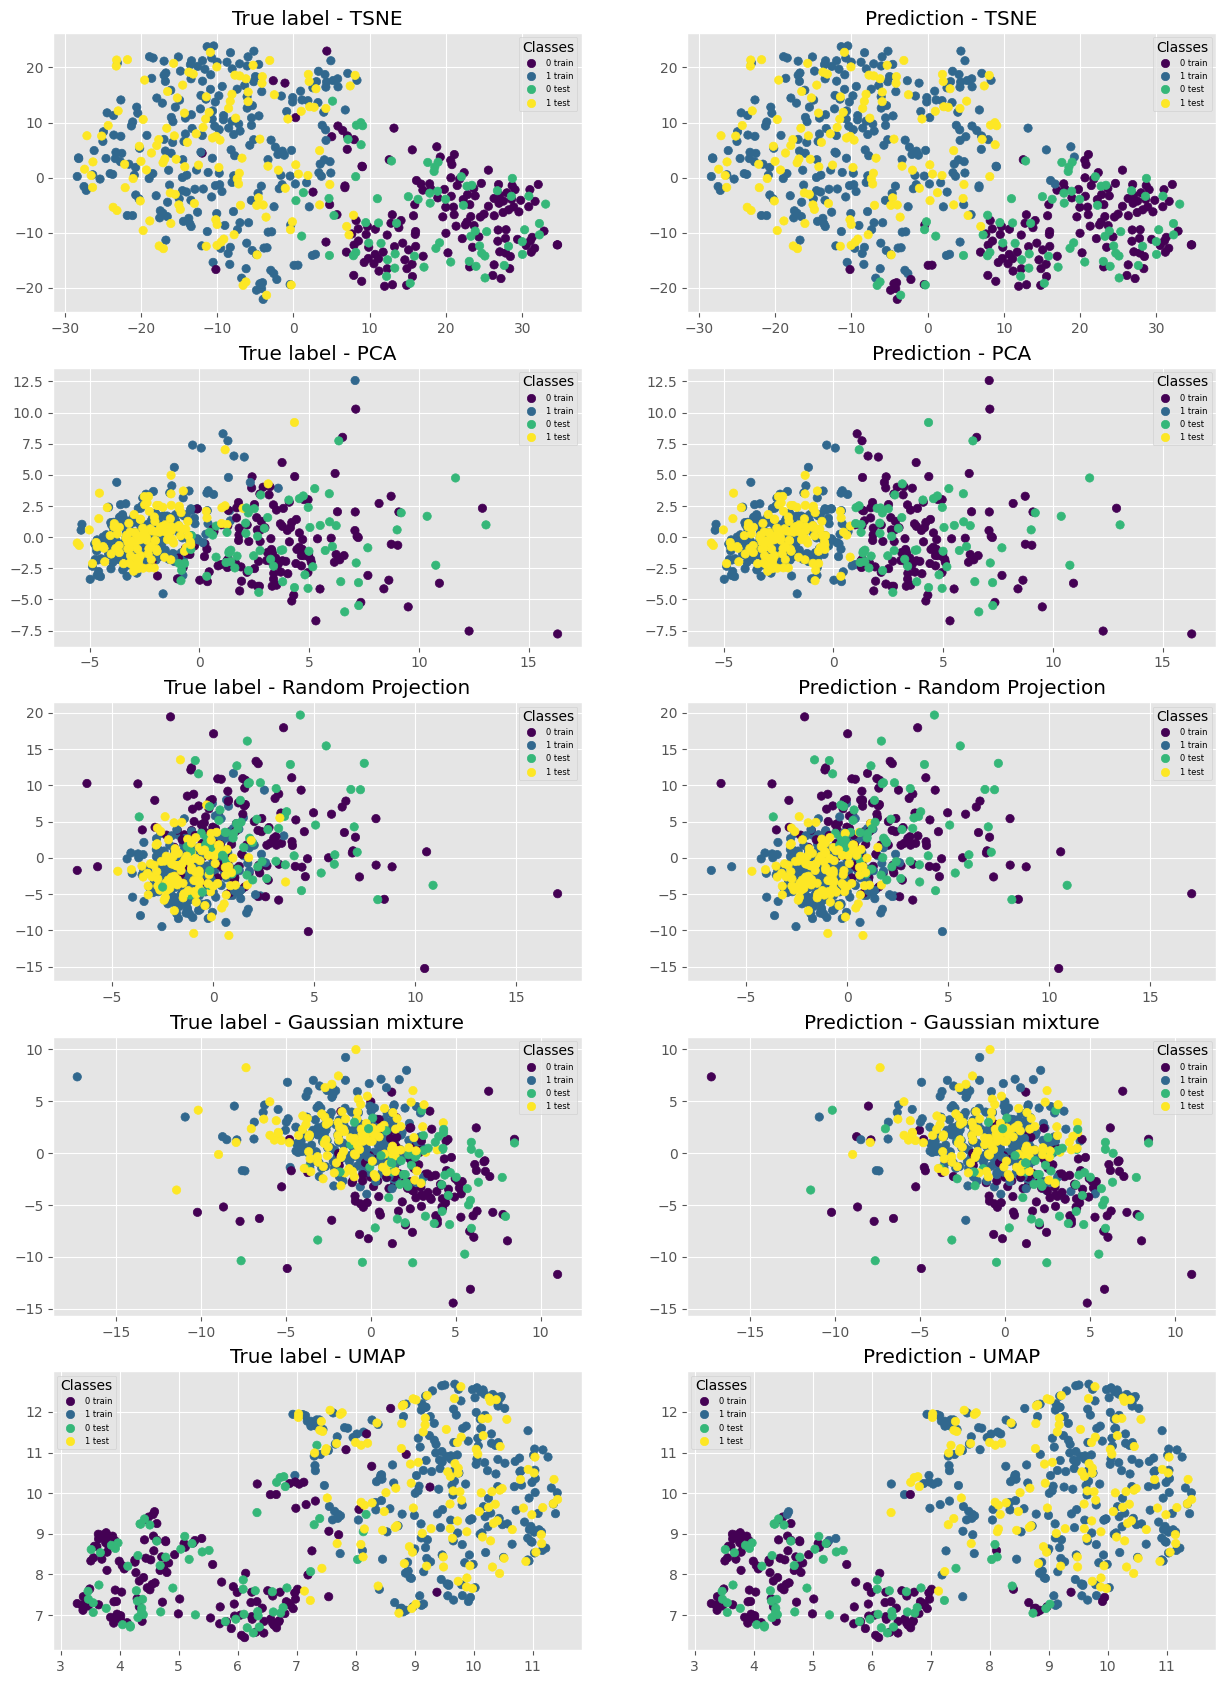

,train,test
recall_score,0.892607,0.884853
precision_score,0.911738,0.893145
accuracy_score,0.908136,0.898936
balanced_accuracy_score,0.892607,0.884853
cohen_kappa_score,0.801193,0.777473
f1_score,0.900429,0.888705
matthews_corrcoef,0.804117,0.777954


In [20]:
kmeans_table = clustering(KMeans(n_clusters=2, random_state=42), 
                          X_train, y_train, X_test, y_test, 
                          labels=labels, 
                          decompositions=decompositions)
kmeans_table

## DBSCAN

In [21]:
EPS = list(np.arange(2, 5, 0.05))
models = [DBSCAN(eps=eps, metric='euclidean', min_samples=20).fit(X) for eps in EPS]
clu = [np.unique(model.labels_).shape[0] for model in models] 

In [22]:
davies_bouldin_score = [sklearn.metrics.davies_bouldin_score(X, model.labels_) for model in models]
calinski_harabasz_score = [sklearn.metrics.calinski_harabasz_score(X, model.labels_) for model in models] 
silhouette_score = [sklearn.metrics.silhouette_score(X, model.labels_, metric='euclidean') for model in models] 

In [23]:
print(f'davies_bouldin_score     [ eps: {EPS[np.argmin(davies_bouldin_score)]:.2f} clusters: {clu[np.argmin(davies_bouldin_score)]}]')
print(f'calinski_harabasz_score  [ eps: {EPS[np.argmax(calinski_harabasz_score)]:.2f} clusters: {clu[np.argmax(calinski_harabasz_score)]}]')
print(f'silhouette_score         [ eps: {EPS[np.argmax(silhouette_score)]:.2f} clusters: {clu[np.argmax(silhouette_score)]}]')

davies_bouldin_score     [ eps: 4.90 clusters: 2]
calinski_harabasz_score  [ eps: 2.80 clusters: 2]
silhouette_score         [ eps: 4.90 clusters: 2]


In [24]:
dbscan = DBSCAN(eps=2.8, metric='euclidean', min_samples=20).fit(X)

In [25]:
list(zip(*np.unique(dbscan.labels_ + 1, return_counts=True)))

[(0, 247), (1, 322)]

confusion matrix (train)
 [[127  18]
 [ 57 179]]

confusion matrix (test)
 [[59  8]
 [36 85]]


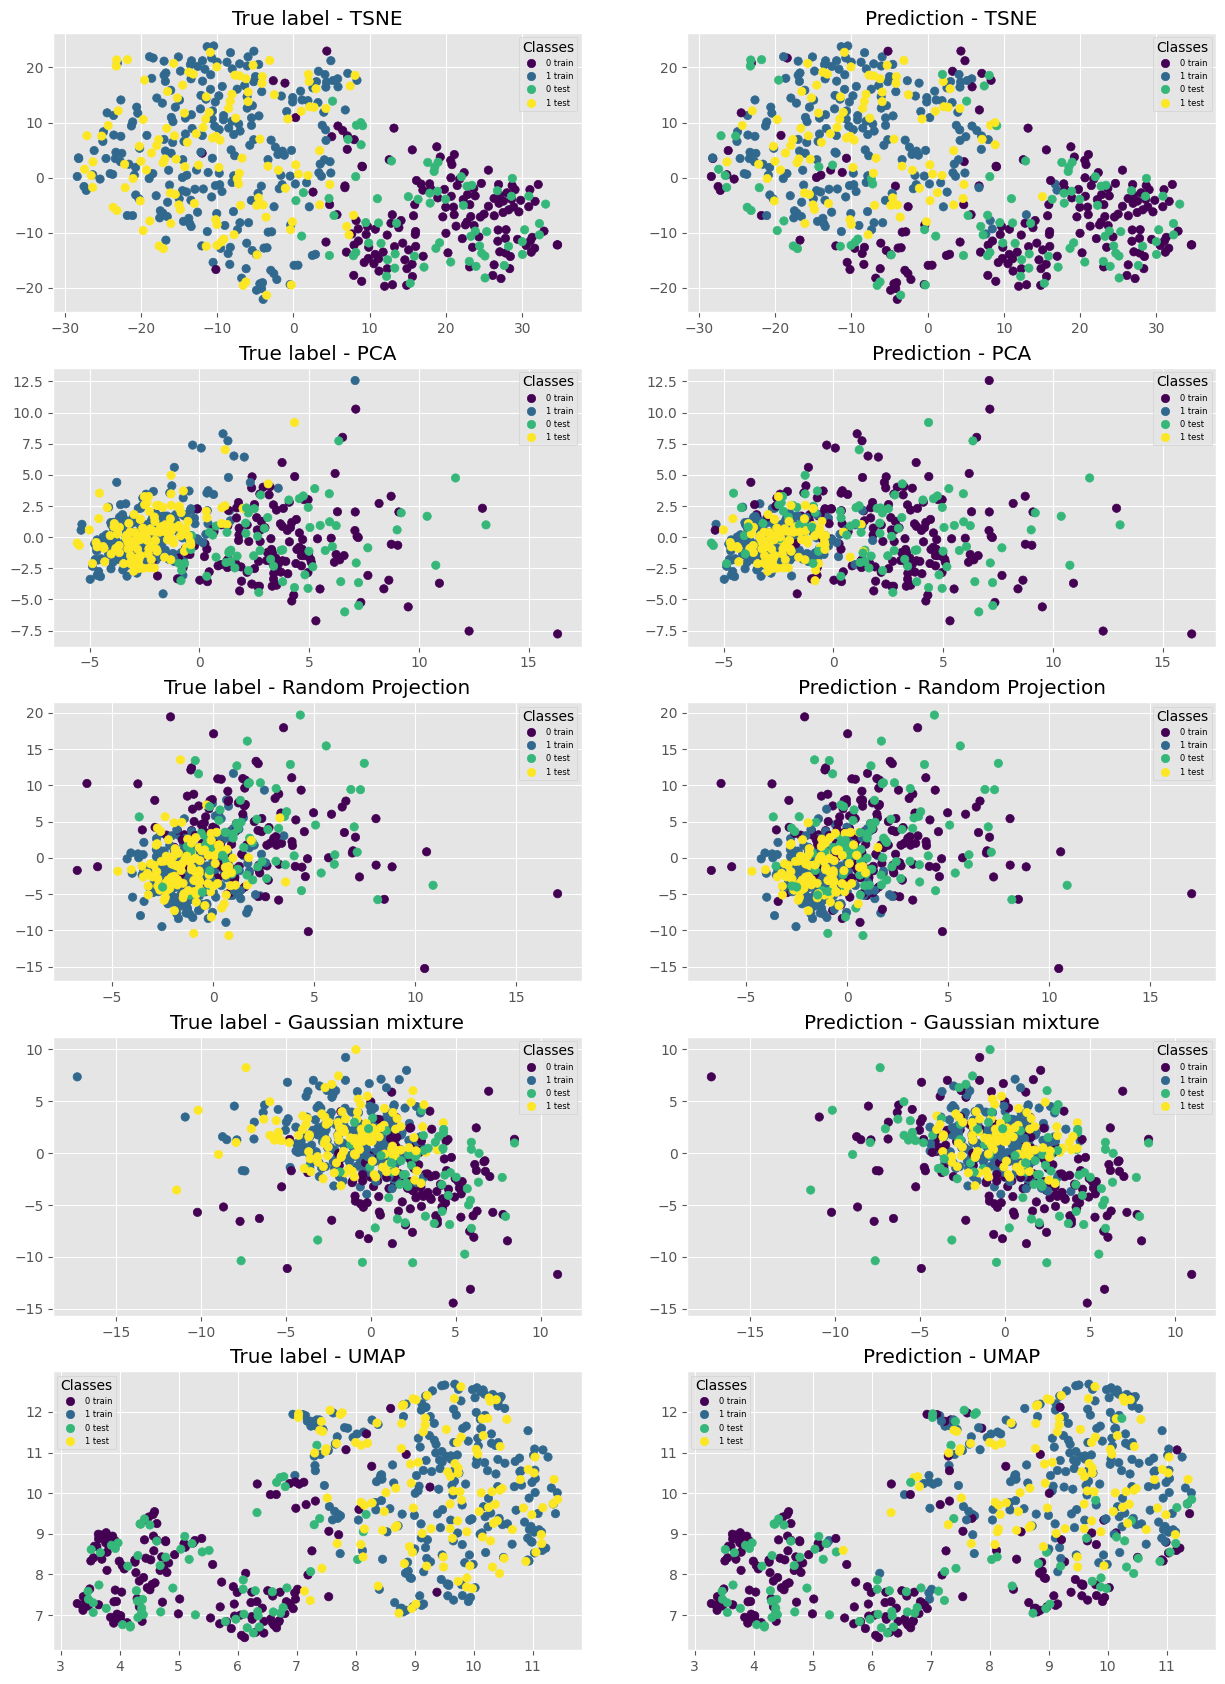

,train,test
recall_score,0.817168,0.791538
precision_score,0.799423,0.767516
accuracy_score,0.803150,0.765957
balanced_accuracy_score,0.817168,0.791538
cohen_kappa_score,0.603064,0.533341
f1_score,0.799413,0.761394
matthews_corrcoef,0.616336,0.558537


In [26]:
dbscan_table = clustering(DBSCAN(eps=2.8, metric='euclidean', min_samples=20), 
                          X_train, y_train, X_test, y_test, 
                          labels=labels, 
                          decompositions=decompositions)
dbscan_table

### Сводная таблица 

In [27]:
pd.concat([kmeans_table, dbscan_table], axis=1)

,train,test,train,test
recall_score,0.892607,0.884853,0.817168,0.791538
precision_score,0.911738,0.893145,0.799423,0.767516
accuracy_score,0.908136,0.898936,0.803150,0.765957
balanced_accuracy_score,0.892607,0.884853,0.817168,0.791538
cohen_kappa_score,0.801193,0.777473,0.603064,0.533341
f1_score,0.900429,0.888705,0.799413,0.761394
matthews_corrcoef,0.804117,0.777954,0.616336,0.558537
